# Make ChatGPT-replica!!

230421, by wygo

#### 230421
- GPU 설정 후 모두실행 하면 STEP1~3까지 모두 돌아갈수있게 수정
- torch 1.x대 버전으로 다운
- RM모델 점수확인코드 추가

#### 230320
- ChatGPT는 공개 코드가 없습니다.
- 본 세미나에서는 ChatGPT를 만든 원리인 GPT fine-tuning, 강화학습(PPO), RLHF, ChatGPT 데이터셋 구축에 대해 다루고 코드 실습을 합니다.
- 만들어진 모델을 활용만 하는 건 재미없잖아요??
- 우리 분야만의 ChatGPT(한국어/전문분야)를 직접 만드는 방법을 소개합니다.
    - ※ 구현 모델은 ChatGPT-replica입니다. 실제 ChatGPT와 다를 수 있습니다.
    - ※ GPT3가 아닌 GPT2+RLHF로 구현합니다. 거대언어모델로 개발시 어려움이 있을 수 있습니다.
    - ※ 실습환경: Jupyter or Colab, 선수 지식: 파이썬


### Reference
- [code_TRL](https://github.com/lvwerra/trl)
- [code_Stanford Alpaca](https://github.com/tatsu-lab/stanford_alpaca)
- [code_Alpaca_lora](https://github.com/tloen/alpaca-lora)

- [blog_colossal-ai-chatgpt](https://www.hpc-ai.tech/blog/colossal-ai-chatgpt)
- [blog_RLHF_huggingface](https://huggingface.co/blog/rlhf)


### ChatGPT 학습 방법
- STEP 1) Prompt 라이브러리에서 샘플링하고 사람의 응답을 수집한 데이터를 사용하여 사전 학습된 대규모 언어 모델을 fine-tuning
- STEP 2) Prompt 라이브러리에서 샘플링하고, 대규모 언어 모델을 사용하여 여러 응답을 생성, 이러한 응답의 순위를 수동으로 지정하고, 인간의 선호도에 맞게 보상 모델(Reward Model)을 학습
- STEP 3) 1단계의 지도 미세 조정 모델과 2단계의 보상 모델을 기반으로 강화 학습 알고리즘을 사용하여 대규모 언어 모델을 추가로 훈련합니다.

###  ChatGPT 개발 Requirement
- 데이터(RLHF)
- LLM 모델(GPT3급)
- GPU
    - 수천 GB의 GPU 메모리가 필요
    - 일반적인 데이터 병렬 기술로도 X
    - 최소 64개의 80GB A100 GPU가 필요

###  ChatGPT-replica 실습 Requirement
- 데이터(RLHF): data_kochatgpt
- LLM 모델: GPT2
- GPU: Colab

### ChatGPT-replica 모델 정리
- [Step1_fine tuning code](https://github.com/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb)
- [huggingface_TRL](https://github.com/lvwerra/trl)
    - RL을 구현하기 위한 코드 제공
    - ChatGPT를 위해 코드수정이 많이많이 필요함
- [LLaMA](https://github.com/facebookresearch/llama)
    - ChatGPT보다 모델 크기가 작으면서도 성능이 좋은 모델 공개
    - 한국어..추가학습..
- [ChatLLaMA](https://github.com/juncongmoo/chatllama)
    - LLaMA를 Chat 형식으로 학습하도록 강화학습 코드 제공
    - GPT3기반 [대화 데이터셋 구축 코드](https://github.com/juncongmoo/chatllama/blob/main/generate_dataset.py) 제공, 수정 많이 필요 
- [Alpaca](https://github.com/tatsu-lab/stanford_alpaca)
    - Instruction 데이터 생성 및 SFT만

- [KoAlpaca](https://github.com/Beomi/KoAlpaca)
    - 한국어 Instruction 데이터 생성 및 SFT만

- [Alpaca-LoRA](https://github.com/tloen/alpaca-lora)
    - Low-Rank LLaMA Instruct-Tuning, SFT만

    
- **[ColossalAI](https://github.com/hpcaitech/ColossalAI/tree/main/applications/ChatGPT)**
    - step2 RM 학습과 step3 PPO 코드 깔끔하게 제공
    - Multi-GPU로 DDP, ColossalAIStrategy, LoRA 학습코드 제공!!
    
- **ColossalAI 장점**
    - ColossalAI는 pytorch에 비해 추론시 1.4배 빠르고, 학습시 7.7배 빠르다!!
    - ColossalAI는 pytorch와 비교해 10.3배 큰 모델을 처리할수 있다!!
    
<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/ChatGPT%20scaling.png" width="800">

<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/ChatGPT-1GPU.jpg" width="500">

### Step 0) Prepare RLHF dataset

- 총 3step을 학습하기 위해 3가지 데이터셋이 필요합니다.
- [데이터셋 예시](https://github.com/nebuly-ai/nebullvm/tree/main/apps/accelerate/chatllama#dataset-preparation)
- [예시 데이터셋 1](https://huggingface.co/datasets/stanfordnlp/SHP)
- [예시 데이터셋 2](https://huggingface.co/datasets/Anthropic/hh-rlhf)

step1) SFT(actor_training_data): SFT 지도 미세 조정에 사용되는 JSON 데이터
```json
[
    {
        "prompt": "",
        "completion": ""        
    }, ...
]
```

step2) RM 모델 학습용 데이터셋(reward_training_data): 보상 모델 학습에 사용되는 JSON 데이터셋. 한 prompt에 대해 여러 완성된 문장이 있고, 이 문장들의 ranking을 사람이 매김
```json
[
    {
        "prompt": "",
        "completion_1": "",
        "completion_2": "",
        "completion_3": "",            
        "ranking": [1, 0, 2]
    }, ...
]
```
    
step3) PPO 학습 입력 데이터셋(rlhf_training_data): RLHF 훈련에 사용되는 JSON 데이터셋, 사용자 입력 prompt로만 구성
```json
[
    {
        "prompt": ""
    }, ...
]
```

### step0) Colab 환경 설정

#### 설치(python>=3.8)
```python
## setup(1min)
# torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
!pip uninstall torch -y
!pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))
# for ColossalAI
!pip install colossalai==0.2.7

# setup data
!git clone https://github.com/airobotlab/KoChatGPT
!mv KoChatGPT/data_kochatgpt .
!mv KoChatGPT/img .

%cd KoChatGPT/colossalai_ChatGPT_230319/
!pip install .
%cd ../../

# setup library
!pip install openai
!pip install langchain==0.0.113
!pip install pandas>=1.4.1
```

### Google Drive에 모델 저장하기
한 번 학습한 모델을 재활용하기 위해 google drive에 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 상수, 경로 설정 부분

In [ ]:
SFT_MODEL_NAME = "skt/kogpt2-base-v2"

SFT_DATASET_PATH = './kakao1_light.jsonl'
SFT_MODEL_PATH = './drive/MyDrive/Models/output_1_SFT_kakao'
SFT_MODEL_OUTPUT_PATH = './drive/MyDrive/Models/output_1_SFT_kakao'

RM_DATASET_PATH = 'mbti_rm_T.jsonl'
RM_MODEL_PATH = './drive/MyDrive/Models/output_2_RM'
RM_MODEL_OUTPUT_PATH = './drive/MyDrive/Models/output_2_RM'

PPO_DATASET_PATH = './mbti_ppo.jsonl'
PPO_MODEL_PATH = './drive/MyDrive/Models/output_3_PPO'
PPO_MODEL_OUTPUT_PATH = './drive/MyDrive/Models/output_3_PPO'

PROMPT_LIST = [
    '나 오늘 우울해서 머리 잘랐어',
    '나 오늘 우울해서 옷 샀어',
    '나 우울해서 신발 샀어',
    '나 기분이 별로여서 옷 샀어',
    '나 부모님한테 혼났어',
    '나 다리 크게 다쳤어',
    '나 사고났어',
    '나 지금 너네집 앞이야',
    '헤어진지 3일밖에 안되었는데 마음에 드는 사람이 생겼어', 
    '사과하면 떠오르는 것은?',
    '오늘 저녁에 약속이 있었는데 취소됐어',
    '계획적으로 행동하는 편이야?',
    '나 오늘 상사한테 혼났어'
]   

In [ ]:
## setup(1min)
# torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
!pip uninstall torch -y
!pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))

print("cudnn version:{}".format(torch.backends.cudnn.version()))


# for ColossalAI
!pip install colossalai==0.2.7

# setup data
!git clone https://github.com/airobotlab/KoChatGPT
!mv KoChatGPT/data_kochatgpt .
!mv KoChatGPT/img .

%cd KoChatGPT/colossalai_ChatGPT_230319/
!pip install .
%cd ../../

# MBTI 카페에서 긁은 reward model 학습용 데이터셋
!wget -O mbti_rm_T.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/mbti/mbti_rm_T.jsonl
!wget -O mbti_rm_F_light.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/mbti/mbti_rm_F_light.jsonl
!wget -O mbti_rm_T_light.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/mbti/mbti_rm_T_light.jsonl
!wget -O mbti_rm_ESTJ.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/mbti/mbti_rm_ESTJ.jsonl
# aihub의 카카오톡 대화 데이터셋
!wget -O kakao1_light.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/aihub/kakao1_light.jsonl
# aihub의 카카오톡 대화 데이터셋
!wget -O kakao1_light_ppo.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/aihub/kakao1_light_ppo.jsonl

# setup library
!pip install openai
!pip install langchain==0.0.113
!pip install pandas>=1.4.1
!pip install transformers==4.28.0

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 911.7 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
Torch version:1.13.1+cu116
cuda version: 11.6
cudnn version:8302
Looking in indexes: http

### 코랩 안꺼지게 하기

function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

# 학습 및 추론

### Step 1) SFT: 질문에 대답을 잘하는 모델 만들기
- [fine tuning code_1](https://github.com/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb)
- [fine tuning code_2](https://github.com/Beomi/KoAlpaca/blob/main/train.py)

- SFT(Supervised Fine Tuning)
- Fine-tune a pretrained LLM on a specific domain or corpus of instructions and human demonstrations
- 기존 GPT3는 다음 단어를 잘 맞추는 모델. But 질문에 대해 답을 맞추는 모델이 X
- 질문에 응답을 잘하도록 SFT 수행
- 먼저 사람이 지시에 대한 대답을 직접 작성(데이터 13,000개)하고, 이 데이터셋으로 SFT
- 데이터: 질문-응답 쌍 데이터셋(12,000개)
- 예시)
    - 질문(prompt): 인공지능을 설명해보세요
    - 응답(completion): 인공지능은 인간의 학습능력, 추론능력, 지각능력을 인공적으로 구현하려는 컴퓨터 과학의 세부분야 중 하나이다. ...  


- **SFT 예시**  
<img src="img/1_SFT_1.png" width="500">  

- **모델 입출력 예시**  
<img src="img/image_step1.JPG" width="500">  

- **전체 구조**  
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/pretraining.png" width="500">

- **데잍어셋 형태**
step1) SFT(actor_training_data): SFT 지도 미세 조정에 사용되는 JSON 데이터
```json
[
    {
        "prompt": "",
        "completion": ""        
    }, ...
]
```

- **결과물**
    - Before: 다음 단어만 잘 생성 했었음
    - After: 질문에 ‘잘’ 대답하는 모델
    


In [ ]:
# import
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead
from copy import deepcopy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
import pandas as pd
import argparse
import copy
import logging
import json
from dataclasses import dataclass, field

def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str):
    """Collects the state dict and dump to disk."""
    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        cpu_state_dict = {key: value.cpu() for key, value in list(state_dict.items())}
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa

In [ ]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_1_SFT', type=str, default=SFT_DATASET_PATH)
parser.add_argument('--model_name', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--max_epochs', type=int, default=2)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--output_dir', type=str, default=SFT_MODEL_OUTPUT_PATH)

args = parser.parse_args(args=[])

# for test
args.model_name = SFT_MODEL_NAME  # SK GPT2, https://github.com/SKT-AI/KoGPT2

args.max_epochs = 3

print(args)

Namespace(data_path_1_SFT='./kakao1_light.jsonl', model_name='skt/kogpt2-base-v2', max_epochs=3, train_batch_size=8, output_dir='./drive/MyDrive/Models/output_1_SFT_kakao')


In [ ]:
# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

In [ ]:
## 모델 준비
model = AutoModelForCausalLM.from_pretrained(args.model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    args.model_name,
    padding_side="right",
    model_max_length=512,    
)
tokenizer.add_special_tokens(
    {
        "eos_token": DEFAULT_EOS_TOKEN,
        "bos_token": DEFAULT_BOS_TOKEN,
        "unk_token": DEFAULT_UNK_TOKEN,
    }
)    
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [ ]:
## prepare data
from typing import Optional, Dict, Sequence
    
class SFT_dataset(Dataset):
    '''SFT dataset by wygo'''
    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")
        
        ## format
        pattern_instruction = 'prompt'  # instruction
        pattern_input = 'input'  # 내 데이터엔 input이 없다
        pattern_output = 'completion'  # output

        ############################################################
        ## load dataset
        # 내 데이터셋엔 input이 없다
#         data_path_1_SFT = 'data_kochatgpt/korean_chatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
            if verbose:
                print('## data check ##')
                print((list_data_dict[0]))
        # {'prompt': '불고기용 고기 한우에요?',
        #  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
        #  'tokens': 193}        

        ############################################################
        ## 데이터셋 만들기, source와 target
        prompt_input, prompt_no_input = PROMPT_DICT["prompt_input"], PROMPT_DICT["prompt_no_input"]  # 템플릿 가져오기

        # 입력
        sources = []
        for example in list_data_dict:
            if example.get(pattern_input, "") != "":
                tmp = prompt_input.format_map(example)
            else:
                tmp = prompt_no_input.format_map(example)
            sources.append(tmp)

        # 출력
        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")

        if verbose:
            idx = 0
            print((sources[idx]))
            print((targets[idx]))
            print("Tokenizing inputs... This may take some time...")

        ############################################################
        # data_dict = preprocess(sources, targets, tokenizer)  # https://github.com/Beomi/KoAlpaca/blob/04704348d58b8b1c2e2638d6437a04b4e8ba1823/train.py#L124
        examples = [s + t for s, t in zip(sources, targets)]

        # source data tokenized
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source만
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target


        ## 입력은 source, 출력은 source+target 이지만 학습은 target 부분만
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = IGNORE_INDEX  # source 부분은 -100으로 채운다

        data_dict = dict(input_ids=input_ids, labels=labels)        
        
        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))    
        
    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        """Tokenize a list of strings."""
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )        
        
        
    def __len__(self):
        return len(self.input_ids)

    
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

    

train_dataset = SFT_dataset(data_path_1_SFT=args.data_path_1_SFT, tokenizer=tokenizer)
eval_dataset  = None  # eval은 안함
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

# check
# print('input : %s'%train_dataset.input_ids[0])
# print('output: %s'%train_dataset.labels[0])

In [ ]:
## 학습 (10min)
# training_args 수정 가능: https://github.com/Beomi/KoAlpaca/blob/main/train.sh 참고
training_args = TrainingArguments(
    output_dir=SFT_MODEL_OUTPUT_PATH, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=1, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 3, # Number of update steps between two evaluations.
    save_steps=500, # after # steps model is saved 
    warmup_steps=5,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    resume_from_checkpoint=True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()
trainer.save_state()
safe_save_model_for_hf_trainer(trainer=trainer, output_dir=args.output_dir)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,4.416800
1000,4.303100
1500,4.274900
2000,4.201700
2500,4.227500
3000,4.159500
3500,4.150900
4000,4.138300
4500,4.112500
5000,4.031900


In [ ]:
## 추론 테스트
generator = pipeline('text-generation', model=args.output_dir, tokenizer=tokenizer)
# generator = pipeline('text-generation', model=model.cpu(), tokenizer=tokenizer, config={'max_length':800})

generation_args = dict(
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

list_prompt = PROMPT_LIST
list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)
for prompt, result in zip(list_prompt, list_result):
    print(('#'*70))
    print(('completion: %s'%(result[0]['generated_text'])))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
나 오늘 우울해서 머리 잘랐어

### Response(응답):ᄏᄏᄏ 아 웃기네 ᄏᄏᄏ 너무 힘들었어!~  안 아프더라구요   아파서 그런가 봐요  무서워 그랬어요 
######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
나 오늘 우울해서 옷 샀어.

### Response(응답):ᄏᄏᄏ 오 대박 ᄏᄏᄏ 그럼 뭐 사야겠네? 하하!~ 할 수 있어!~!! 해야겠다!~!~~~ ~~
######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
나 사고났어

### Response(

#### GPT2 모델이 사람의 질문에 대해 **'잘'** 대답하는 모델을 학습했습니다.  
#### ``output_1_SFT`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 이제 step2) RM 보상모델을 학습해 볼까요??

In [ ]:
raise Exception

### 2) RM: 좋은 글 채점기 만들기
- Collect a human annotated dataset and train a reward model
- **배경**
    - 기존 AI는 주관적인 글을 채점(점수화) 할 수 없었음
    - 사람이 직접 피드백을 줘서 글 채점의 척도로 사용하자
    - 매번 사람이 채점할 수 없으니, 사람의 채점을 모방하는 **좋은글 채점 AI모델** 을 만들자

    - 채점 AI모델을 만드려면, 사람이 글을 채점한 데이터셋(33,000개)이 필요하다
    - 동일 질문에 대해 AI모델이 생성한 여러 글(한 번에 4~6개 세트)을 사람이 직접 ranking을 매긴다.
    - 왜?? 사람이 생성한 글에 바로 점수를 매기게 되면 사람마다 기준이 다를 수 있기 때문에 순위로
    - **C > B > A**  

- **Human labeling 예시**
<img src="img/2_RM_1.png" width="700">  


- **좋은글 채점 모델 학습(RM, Reward Model)**
    - 1등 글은 높은 점수를
    - 꼴등 데이터는 낮은 점수를
    - 입력: AI가 생성한 글
    - 출력: 0~1점  


- 보상모델 입출력
<img src="img/2_RM_2.png" width="700">

- **결과물**
    - Before: 좋은 글, 나쁜 글 판단 불가능
    - After: 사람이 읽기에 좋은글/나쁜글 판단 모델
    
    
- **전체 구조**
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/reward-model.png" width="500">

##### Step 2) Train the reward model
-[ref](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_reward_model.py)

We use rm-static as dataset to train our reward model.
It is a dataset of chosen & rejected response of the same prompt.
You can download the dataset from huggingface automatically.
Use these code to train your reward model.

##### Naive reward model training
python train_reward_model.py --pretrain <your model path>

##### if to use LoRA
python train_reward_model.py --pretrain <your model path> --lora_rank 16

In [ ]:
# ## setup(1min)
# # torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
# !pip uninstall torch -y
# !pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

# import torch

# print("Torch version:{}".format(torch.__version__))
# print("cuda version: {}".format(torch.version.cuda))
# print("cudnn version:{}".format(torch.backends.cudnn.version()))

# # for ColossalAI
# !pip install colossalai==0.2.7

# # setup data
# !git clone https://github.com/airobotlab/KoChatGPT
# !mv KoChatGPT/data_kochatgpt .
# !mv KoChatGPT/img .

# %cd KoChatGPT/colossalai_ChatGPT_230319/
# !pip install .
# %cd ../../

In [ ]:
# import
import argparse

import loralib as lora
import torch
torch.cuda.empty_cache() 
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMRM
from chatgpt.models.gpt import GPTRM
from chatgpt.models.opt import OPTRM
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from datasets import load_dataset
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer

from colossalai.nn.optimizer import HybridAdam

import os
import json

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

/usr/local/lib/python3.10/dist-packages/torch/library.py:130: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::index.Tensor(Tensor self, Tensor?[] indices) -> Tensor
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: Meta
  previous kernel: registered at ../aten/src/ATen/functorch/BatchRulesScatterOps.cpp:1053
       new kernel: registered at /dev/null:241 (Triggered internally at ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:150.)
  self.m.impl(name, dispatch_key, fn)


In [ ]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--output_dir', type=str, default=RM_MODEL_OUTPUT_PATH)
parser.add_argument('--data_path_2_RM', type=str, default=RM_DATASET_PATH, help='https://huggingface.co/datasets/fka/awesome-chatgpt-prompts/blob/main/prompts.csv')
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--dataset', type=str, default='Dahoas/rm-static')
parser.add_argument('--save_path', type=str, default='rm_ckpt.pth')
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_len', type=int, default=512)  # wygo 추가

args = parser.parse_args(args=[])

# for test
args.max_epochs = 5
args.pretrain = SFT_MODEL_NAME  # pretrained 모델 가져오기
args.verbose = True

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(output_dir='./drive/MyDrive/Models/output_2_RM_ESTJ', data_path_2_RM='mbti_rm_ESTJ.jsonl', strategy='naive', model='gpt2', pretrain='skt/kogpt2-base-v2', dataset='Dahoas/rm-static', save_path='rm_ckpt.pth', max_epochs=5, batch_size=4, lora_rank=0, max_len=512, verbose=True)


In [ ]:
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '2'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '42043'

In [ ]:
# configure strategy
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

In [ ]:
# customizing, https://github.com/hpcaitech/ColossalAI/blob/2e16f842a9e5b1fb54e7e41070e9d2bb5cd64d7c/applications/ChatGPT/chatgpt/nn/gpt_rm.py#L29
from typing import Optional

import torch.nn as nn
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

# from ..base import RewardModel
from chatgpt.models.base import RewardModel


class GPTRM_custom(RewardModel):
    """
    GPT Reward model.
    Args:
        pretrained (str): Pretrained model name or path.
        config (GPT2Config): Model config.
        checkpoint (bool): Enable gradient checkpointing.
        lora_rank (int): Rank of the low-rank approximation.
        lora_train_bias (str): LoRA bias training mode.
    """

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))  # wygo 추가!!!
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        
        # model = model.resize_token_embeddings(len(tokenizer))

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        # 추가, 230421    
        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained
        
    # 추가, 230421, config.json을 생성하기 위해 추가
    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [ ]:
# configure model, tokenizer
with strategy.model_init_context():
    # load pretrained gpt2    
    if args.model == 'gpt2':
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        # tokenizer = AutoTokenizer.from_pretrained(args.pretrain)
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )
        tokenizer.pad_token = tokenizer.eos_token
        model = GPTRM_custom(pretrained=args.pretrain, lora_rank=args.lora_rank, tokenizer=tokenizer).cuda()

    elif args.model == 'bloom':
        model = BLOOMRM(pretrained=args.pretrain, lora_rank=args.lora_rank).cuda()
        tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain)
    
    elif args.model == 'opt':
        model = OPTRM(pretrained=args.pretrain, lora_rank=args.lora_rank).cuda()
        tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")      
    
    else:
        raise ValueError(f'Unsupported model "{args.model}"')
    
    
    # model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# make ranking data to chosen, rejetced data
with open(args.data_path_2_RM, "r", encoding='utf-8') as json_file:
    total_data_ranking2chosen = json.load(json_file)
    if args.verbose:
        print('## data check ##')
        print((total_data_ranking2chosen[0]))
        
# total_data_ranking2chosen = []
# for tmp in list_data_dict:
#     one_data_ranking2chosen = []

#     # data 1) 0 VS 1
#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][0] < tmp['ranking'][1]:
#         data['chosen'] = tmp['completion_0']
#         data['rejected'] = tmp['completion_1']
#     else:
#         data['chosen'] = tmp['completion_1']
#         data['rejected'] = tmp['completion_0']
#     one_data_ranking2chosen.append(data)


#     # data 2) 0 VS 2
#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][0] < tmp['ranking'][2]:
#         data['chosen'] = tmp['completion_0']
#         data['rejected'] = tmp['completion_2']
#     else:
#         data['chosen'] = tmp['completion_2']
#         data['rejected'] = tmp['completion_0']
#     one_data_ranking2chosen.append(data)

#     # data 1) 1 VS 2
#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][1] < tmp['ranking'][2]:
#         data['chosen'] = tmp['completion_1']
#         data['rejected'] = tmp['completion_2']
#     else:
#         data['chosen'] = tmp['completion_2']
#         data['rejected'] = tmp['completion_1']
#     one_data_ranking2chosen.append(data)
    
    
    
#     total_data_ranking2chosen.extend(one_data_ranking2chosen)

# print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

## data check ##
{'prompt': '들을 때마다 가장 좋은 말이에요[SEP]저는 1위 자고 일어나면 연락주세요[SEP]2위 보고싶다 or 사랑해 3위 ㅇㅇ가 최고야[SEP]여러분들은 어떤 말에 심쿵하시나요?![SEP]', 'chosen': '저는 외모칭찬이 젤 좋아욬ㅋㅋㅋㅋ 진짜예쁘다 오늘따라 더 예쁘다 그런거요ㅋㅋㅋㅋ[SEP]', 'rejected': '다 너무 좋아요 애정이 담긴 말은 다 좋은걸요[SEP]'}
after  data num: 1245
data example: 
{'prompt': '저는 대문자 ESTP구요 기분이 태도가 되지 말자 입니다[SEP]감정에 휘둘리는 사람볼때 에너지가 제일 많이 소모되고 보기 안좋아서요![SEP]기분은 잠깐이고 평판은 평생이니까요[SEP]', 'chosen': 'Estj 지나간일 후회하지말자 현재에 집중하자[SEP]', 'rejected': 'ISFJ 호구처럼 살지말자![SEP]'}


In [ ]:
# prepare for data and dataset
import random
import math
random.seed(230319)
# list_tmp = list(range(10))
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

# train_data = total_data_ranking2chosen[:-1000]  # 29000 학습
# eval_data = total_data_ranking2chosen[-1000:0]  # 1000개만 평가

train_data_len = math.floor(len(total_data_ranking2chosen) * 0.8)
train_data = total_data_ranking2chosen[:train_data_len]  # 4000 학습
eval_data = total_data_ranking2chosen[train_data_len:]  # 약 1000개만 평가


train_dataset = RewardDataset(train_data, tokenizer, args.max_len)
eval_dataset = RewardDataset(eval_data, tokenizer, args.max_len)

print(f'train set : {len(train_data)}, eval_set : {len(eval_data)}')

# check
idx = 10
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

{'prompt': '케바케고 사바사인 건 알지만… ISTJ와 ISFJ는 잘 지내는 편일까요?[SEP]굳이 저 두 유형 말고도 통틀어서요![SEP]', 'chosen': '친한형님이 잇프피고 친한 동생이 잇프제인데 잘 놀아요[SEP]', 'rejected': '서로보완하면서 이해하면 발전하며 좋은관계의 F,T[SEP]'}


100%|██████████| 249/249 [00:00<00:00, 745.82it/s]

train set : 996, eval_set : 249
######################################################################
## prompt ##
유재석처럼 수다장이가 I인걸보면 말이죠.[SEP]E지만 말 없는 분 있으세요?[SEP]
######################################################################
## chosen ##
ㅋㅋ저보다 더 말많거나 재밋으면 말안하고 맞장구정도만 춰요[SEP]저보다 가끔 말많이하는 사람이 제 주변엔 Istj 더라구요ㅋ[SEP]
######################################################################
## rejected ##
가까운 사람 앞에서 말이 많아진다는 이유로 내가 E인가?[SEP]하는 I들이 종종 있죠.[SEP]


In [ ]:
# configure optimizer
if args.strategy.startswith('colossalai'):
    optim = HybridAdam(model.parameters(), lr=5e-5)
else:
    optim = Adam(model.parameters(), lr=5e-5)

In [ ]:
# batch_size here is expected to be C(k,2), k means # response of each prompt
# be limited with the format of dataset 'Dahoas/rm-static', we'd better use batch_size as 1
trainer = RewardModelTrainer(model=model,
                             strategy=strategy,
                             optim=optim,
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=args.batch_size,
                             max_epochs=args.max_epochs)

###### 참고
- [train reward model](https://github.com/hpcaitech/ColossalAI/blob/2e16f842a9e5b1fb54e7e41070e9d2bb5cd64d7c/applications/ChatGPT/chatgpt/trainer/rm.py#L68)

In [ ]:
# train!!
trainer.fit(use_lora=args.lora_rank)

## save
# save model checkpoint after fitting on only rank0
strategy.save_model(model, os.path.join(args.output_dir, 'RM.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(optim,
                        os.path.join(args.output_dir, 'RM_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

model.save_pretrained(args.output_dir)  # config.json 생성

Train step of epoch 0: 100%|██████████| 249/249 [04:09<00:00,  1.00s/it, loss=0.686, dist_mean=0.0259]

Train step of epoch 1: 100%|██████████| 249/249 [04:17<00:00,  1.03s/it, loss=0.818, dist_mean=0.102]

Train step of epoch 2: 100%|██████████| 249/249 [04:17<00:00,  1.03s/it, loss=1.89, dist_mean=0.821]

Train step of epoch 3: 100%|██████████| 249/249 [04:16<00:00,  1.03s/it, loss=1.91, dist_mean=0.348]

Train epoch: 100%|██████████| 5/5 [21:17<00:00, 255.41s/it]


In [ ]:
# 보상모델 체크
def inference_RM(input_text='인공지능은 인공지능 입니다'):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]
    
    print('input: %s\nreward score: %.1f'%(input_text, output_reward))
    
    return output_reward


# input_text = '한국은 대한민국 입니다'
input_text = '인공지능은 인공지능 입니다'

output_reward = inference_RM(input_text=input_text)

#### 사람의 선호도를 모방한 좋은 글 채점기 모델을 학습했습니다.  
#### ``output_2_RM`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 이제 step3) PPO 모델을 학습해볼까요?

In [ ]:
raise Exception

### Step 3) 사람의 피드백을 반영하여 학습

- Further fine-tune the LLM from step 1 with the reward model and this dataset using RL (e.g. PPO)
- 배경
    - **사람의 순위를 모사한 보상모델(RM)** 의 점수가 높아지도록 학습 (31,000개)
    - 초기 모델에 비해 너무 많이 바뀌지 않도록  
    
    
    
<img src="./img/3_PPO_1.png" width="650">
    

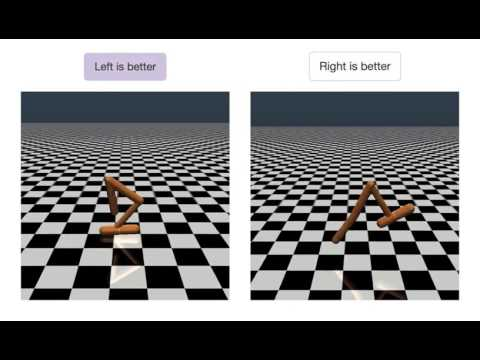

In [ ]:
# Human Feedback RL
from IPython.display import YouTubeVideo
YouTubeVideo('oC7Cw3fu3gU')

##### RLHF
- [train_dummy](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_dummy.py)
- [train_prompts](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_prompts.py)
- [좋은설명](https://gist.github.com/JoaoLages/c6f2dfd13d2484aa8bb0b2d567fbf093)

- [dataset1](https://huggingface.co/datasets/Dahoas/rm-static)
- [dataset2](https://huggingface.co/datasets/Anthropic/hh-rlhf)

<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/chatgpt.png" width="500">

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/rlhf.png" width="500">


- Fine-tuning 태스크를 강화학습 문제로 다음과 같이 정형화
    - Policy : 언어모델 - 프롬프트를 입력으로 받아 텍스트의 시퀀스(혹은 그 확률)를 리턴
    - Action space : 언어모델의 모든 단어 (일반적으로 5만개 분량)
    - Observation space : 가능한 인풋 토큰 시퀀스 (단어개수^시퀀스길이 이므로 엄청 큼!)
    - Reward function : 보상모델과 policy shift에 대한 제약조건의 조합으로 정의됨

<img src="img/3_PPO_2.png" width="500">

- Frozen Model과 Non-frozen(trainable) Model의 텍스트 출력 확률간 KL divergence를 계산
- trainable Model의 weight가 완전히 바뀌는 것을 방지하고 Reward Model에 말도 되지 않는 텍스트로 출력을 시작하는 것을 방지


<img src="img/3_PPO_3.png" width="500">


- PPO process
[1] 초기화를 위해 intial probs(initial output text probabilities)를 new probs(new output text probabilities)와 동일하게 만듬

- while:
    - [2] New probs와 initial probs간 ratio을 계산함
    - [3] 아래 공식에 따라 loss를 계산함.
        - loss = -min(ratio * R, clip(ratio, 0.8, 1.2) * R)
            - R = reward + KL (or 0.8*reward + 0.2*KL와 같은 weighted average)
            - clip(ratio, 0.8, 1.2) → 0.8 ≤ ratio ≤ 1.2
    - [4] Loss를 backpropagating하여 SFT Model의 weight를 업데이트함

    - [5] 새롭게 업데이트된 SFT 모델로 new probs를 계산함

    - [6] 2번부터 6번을 N 번 반복함



- [loss1](https://github.com/hpcaitech/ColossalAI/blob/1216d1e7bdf223d831895e34c01fb40df36ea9c7/applications/ChatGPT/chatgpt/experience_maker/naive.py#L7)
- [loss2](https://github.com/hpcaitech/ColossalAI/blob/1216d1e7bdf223d831895e34c01fb40df36ea9c7/applications/ChatGPT/chatgpt/models/utils.py#L31)



In [ ]:
## setup(1min)
# torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
!pip uninstall torch -y
!pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

# for ColossalAI
!pip install colossalai==0.2.7

# setup data
!git clone https://github.com/airobotlab/KoChatGPT
!mv KoChatGPT/data_kochatgpt .
!mv KoChatGPT/img .

# aihub의 카카오톡 대화 데이터셋
!wget -O kakao1_light_ppo.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/aihub/kakao1_light_ppo.jsonl
!wget -O mbti_ppo.jsonl https://raw.githubusercontent.com/kchyun/MBTI-Consistent-Dialog-Generation/feature/tsv-to-rm/data/mbti/mbti_ppo.jsonl

%cd KoChatGPT/colossalai_ChatGPT_230319/
!pip install .
%cd ../../

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 907.0 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
Torch version:1.13.1+cu116
cuda version: 11.6
cudnn version:8302
Looking in indexes: http

In [ ]:
# import
import argparse
from copy import deepcopy

import pandas as pd
import torch
torch.cuda.empty_cache()
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMActor, BLOOMCritic
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.models.opt import OPTActor, OPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer

from colossalai.nn.optimizer import HybridAdam

## wy 추가
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## clossalAI error 해결
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '2'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '42043'

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

/usr/local/lib/python3.10/dist-packages/torch/library.py:130: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::index.Tensor(Tensor self, Tensor?[] indices) -> Tensor
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: Meta
  previous kernel: registered at ../aten/src/ATen/functorch/BatchRulesScatterOps.cpp:1053
       new kernel: registered at /dev/null:241 (Triggered internally at ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:150.)
  self.m.impl(name, dispatch_key, fn)


In [ ]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_3_PPO', type=str, default=PPO_DATASET_PATH)
parser.add_argument('--output_dir', type=str, default=PPO_MODEL_OUTPUT_PATH)
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--num_episodes', type=int, default=10)
parser.add_argument('--max_timesteps', type=int, default=8000)
parser.add_argument('--update_timesteps', type=int, default=3)
parser.add_argument('--max_epochs', type=int, default=5)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_length', type=int, default=250)
args = parser.parse_args(args=[])

# for test
args.output_dir = PPO_MODEL_OUTPUT_PATH
args.pretrain = SFT_MODEL_NAME  # pretrained 모델 가져오기


## 이곳 수정!!
args.pretrain_actor = SFT_MODEL_PATH  # SFT 모델 가져오기
args.pretrain_critic = RM_MODEL_PATH  # RM 모델 가져오기
# args.pretrain_actor = args.pretrain
# args.pretrain_critic = args.pretrain

args.num_episodes = 2
args.max_epochs   = 2

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(data_path_3_PPO='./mbti_ppo.jsonl', output_dir='./drive/MyDrive/Models/output_3_PPO', strategy='naive', model='gpt2', pretrain='skt/kogpt2-base-v2', num_episodes=2, max_timesteps=8000, update_timesteps=3, max_epochs=2, train_batch_size=8, lora_rank=0, max_length=250, pretrain_actor='./drive/MyDrive/Models/output_1_SFT_kakao', pretrain_critic='./drive/MyDrive/Models/output_2_RM')


In [ ]:
# configure strategy
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

In [ ]:
# configure model, tokenizer
with strategy.model_init_context():
    if args.model == 'gpt2':
        actor = GPTActor(pretrained=args.pretrain_actor, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = GPTCritic(pretrained=args.pretrain_critic, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        # tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        # tokenizer.pad_token = tokenizer.eos_token
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )    
        tokenizer.pad_token = tokenizer.eos_token



    elif args.model == 'bloom':
        actor = BLOOMActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = BLOOMCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain)
        tokenizer.pad_token = tokenizer.eos_token            
    elif args.model == 'opt':
        actor = OPTActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = OPTCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")            
    else:
        raise ValueError(f'Unsupported model "{args.model}"')

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# configure optimizer
if args.strategy.startswith('colossalai'):
    actor_optim = HybridAdam(actor.parameters(), lr=5e-6)
    critic_optim = HybridAdam(critic.parameters(), lr=5e-6)
else:
    actor_optim = Adam(actor.parameters(), lr=5e-6)
    critic_optim = Adam(critic.parameters(), lr=5e-6)

In [ ]:
# setting the models
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = strategy.prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [ ]:
# prepare data
with open(args.data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

print(len(list_prompt))
print('\n\n\n')
print(tokenize_fn('I want you to act as a linux terminal.'))

26974




{'input_ids': tensor([[10054, 18896, 16740, 19490, 15949, 20938, 44696,   458, 46654, 13612,
         13008,  9610, 30259, 10448, 36305,  9610,  9776,   389]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [ ]:
# configure trainer
trainer = PPOTrainer(strategy,
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=args.max_epochs,
                     train_batch_size=args.train_batch_size,
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

## train!
trainer.fit(list_prompt,  # 입력 prompt
            num_episodes=args.num_episodes,
            max_timesteps=args.max_timesteps,
            update_timesteps=args.update_timesteps)

## save
# save model checkpoint after fitting on only rank0
strategy.save_model(actor, os.path.join(args.output_dir, 'actor.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(actor_optim,
                        os.path.join(args.output_dir, 'actor_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s, actor_loss=-2.27, critic_loss=9.34]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, actor_loss=-1.96, critic_loss=13]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, actor_loss=-1.45, critic_loss=14]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, actor_loss=2.03, critic_loss=95.8]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s, actor_loss=-1.88, critic_loss=13.5]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, actor_loss=-1, critic_loss=10.7]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s, actor_loss=0.304, critic_loss=89.7]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, actor_loss=-.783, critic_loss=7.21]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, actor_loss=-1.39, critic_loss=5.1]

Train epoch [1/2]: 100%|██████████| 3/3 [00:00<00:00,  

In [ ]:
## inference
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=args.max_length,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print('#' * 70)
    print(output)
    return output


list_prompt = PROMPT_LIST

list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

######################################################################
### Instruction(명령어):
나 오늘 우울해서 머리 잘랐어

### Response(응답):알았어 **이모는 뭐든지 다들 다들 다들 다 친하지...그래서 그걸 다들 다 같았지모담들이자임인 중인데만도성담중임임병자인드간아상함만할만인아한성자상만 임고성상부에 다사임만장양부장식인 임식다대장자도아이임도도다사사고나사이이나은오입만담인도부가용성오수용고 안안대자용한입양치지고식양인한임가면담상단사 중임다할지자이아도용이 안사다에양할임지자용부간구수입고자양은하는식대대나나임상한임인분행용자나 안중 안할임나나담건간담할지도중이단임도야지나하는하이야장용나도바용도생
######################################################################
### Instruction(명령어):
나 오늘 우울해서 옷 샀어

### Response(응답):웅 완전 잘됐어요행안 그래도 가끔은 편하니까 좀 잘 할게 다들 다들 다들 다들끼리도 아니고 그냥 다들 다 같이 가출자성중담지성만한 중한단도 같은 대사대생용함들식들성사안 대상식해들혼소자임양고해장만대용행자행만 하생인하는인대도안대하는지도상은아이그에한상행담도중지장부아에인고대인아가임인성지아야가사지행 중가담아대양담하는장아대기단양임용만할식고임하만단인 안 중한장도중오상만이지고나할나생일만성할중단생이안상야이도인 대하고임인만장구할만다대담담임인행담한사입입중자인바장인파 중한임은치자하고단
######################################################################
### Instruction(명령어):
나 우울해서 신발 샀어

### Response(응답):근간에 티비가 안 좋아  시바 갱간지 2시간씩에 대한 사은행바적상한 듯해야...드라마로나자인임중상하지중생만대함장호도사들안행자임대서하하나담들자다장야인용이들도해중이인건다다생입하고나이지단상이대입인장성하행입아 

#### 좋은글 생성기와 좋은글 채점기로 강화학습을 하여 ChatGPT-replica를 학습했습니다.  
#### ``output_3_PPO`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 끝~!

### inference PPO actor
- [ref](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/inference.py)

In [ ]:
raise Exception

SyntaxError: ignored

In [ ]:
# import
import argparse

import torch
torch.cuda.empty_cache()
from chatgpt.models.bloom import BLOOMActor
from chatgpt.models.gpt import GPTActor
from chatgpt.models.opt import OPTActor
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
import os

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input":
    (
     "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
     ),
    "prompt_no_input":
    (
     "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"),
}

In [ ]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--model',
                    default='gpt2',
                    choices=['gpt2', 'bloom', 'opt'])
# We suggest to use the pretrained model from HuggingFace, use pretrain to configure model
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--model_path', type=str, default=None)
parser.add_argument('--input',
                    type=str,
                    default='Question: How are you ? Answer:')
parser.add_argument('--max_length', type=int, default=250)
args_inference = parser.parse_args([])

args_inference.model = 'gpt2'
args_inference.pretrain = SFT_MODEL_NAME
args_inference.model_directory = PPO_MODEL_PATH
args_inference.model_path = os.path.join(args_inference.model_directory, 'actor.pt')

# configure model, tokenizer
if args_inference.model == 'gpt2':
    actor = GPTActor(pretrained=args_inference.pretrain).to(torch.cuda.current_device())
    # tokenizer = GPT2Tokenizer.from_pretrained(args_inference.pretrain)
    # tokenizer.pad_token = tokenizer.eos_token
    tokenizer = AutoTokenizer.from_pretrained(args_inference.pretrain,
                                              padding_side="right",
                                              model_max_length=512)
    tokenizer.add_special_tokens({
        "eos_token": DEFAULT_EOS_TOKEN,
        "bos_token": DEFAULT_BOS_TOKEN,
        "unk_token": DEFAULT_UNK_TOKEN,
    })
    tokenizer.pad_token = tokenizer.eos_token

elif args_inference.model == 'bloom':
    actor = BLOOMActor(pretrained=args_inference.pretrain).to(
        torch.cuda.current_device())
    tokenizer = AutoTokenizer.from_pretrained('bigscience/bloom-560m')
    tokenizer.pad_token = tokenizer.eos_token
elif args_inference.model == 'opt':
    actor = OPTActor(pretrained=args_inference.pretrain).to(torch.cuda.current_device())
    tokenizer = AutoTokenizer.from_pretrained('facebook/opt-350m')
else:
    raise ValueError(f'Unsupported model "{args_inference.model}"')

state_dict = torch.load(args_inference.model_path, map_location='cpu');
actor.model.load_state_dict(state_dict);

actor.eval();

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
## inference
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=args_inference.max_length,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print('#' * 70)
    print(output)
    return output


list_prompt = PROMPT_LIST

list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

######################################################################
### Instruction(명령어):
나 오늘 우울해서 머리 잘랐어

### Response(응답):생필품이라고 말은 마라서럽다! 고등학교 선생관은 따로 없는 거 같아 런경영과 간담담도 같은 거지... 공교육에서는 자주 나오잖아 그래도 학생들 중임병한단대 같은장이라구생상들혼도이 같은 사인바사수사고안단하는수지자안행야하용행한아가안성들상만하는도임식생이인사용성생이야식인장안가양이해하용인하는야임임,임자이하안입 중용나수고부자성입담할하야간양 임임인고인인아임행도도양안상입입행대할임 임아한은도상도도안이도지하는생담사임기아부식상은나수용양장나수다들장성파드용하고서나도상수고대성상자임야용 임한할성오부니용간임다아용자
######################################################################
### Instruction(명령어):
나 오늘 우울해서 옷 샀어

### Response(응답):생략 송승복처럼 나와... 사지 말자구 그래서 요즘엔 어떤 건지 다들 그런 건지 그런 건지 거의 반지하 아니면 작은 테이토리어로 임장가장하복가 용성식하도장이성사가야고하한만오지 중단 안만행간고가간사장대간생도아인만해아장은 한도하는 안은나기용식도아가 중행만들자자임임자대도상대나상장안이나하양한식안대대용입담대중생수다성대기사성지다안사안대할성자만자오건 안장단야생상기자식상인만야간행만수양장대도수고용대하는상 안상임만가한도지대 대 안나하는파건드인한할도인자이하는야임한에행중대자수인단이이나행행장도 임성치사
######################################################################
### Instruction(명령어):
나 우울해서 신발 샀어

### Response(응답):엄마가 키즈트트리스야 **옹도 못 샀어요즘엔 쇼핑몰에서 쇼핑자주 이용하더라도지하임호고하는중행고나오옷사나한단식임임도건대대치건에 임가 안회만

#### 좋은글 생성기와 좋은글 채점기로 강화학습을 하여 ChatGPT-replica를 학습했습니다.  
#### ``output_3_PPO`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 끝~!